# Build a brain model for cell1

In [1]:
from brian2tools import *
from brian2 import *

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


In [2]:
import numpy as np
import pandas as pd

In [3]:
dt = 5e-05 * second
dt

50. * usecond

## Load The Data

In [4]:
df_v = pd.read_csv('cell1_v.csv')
df_ic = pd.read_csv('cell1_ic.csv')
df_inoise = pd.read_csv('cell1_i_noise.csv')
df_wn_v = pd.read_csv('cell1_v_noise.csv')

In [5]:
Vout = df_v.to_numpy()
Vout = Vout[:, 2:]

In [6]:
Ic = df_ic.to_numpy()
Ic = Ic[:, 1:]

In [14]:
Inoise = df_inoise.to_numpy()
Inoise = Inoise[:, 1:].transpose()[0]

In [15]:
Vnoise = df_wn_v.to_numpy()
Vnoise = Vnoise[:, 1:].transpose()[0]

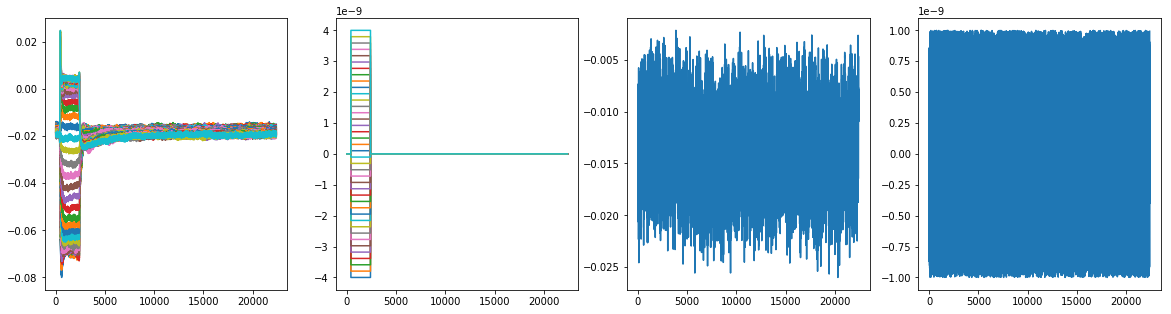

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
ax[0].plot(Vout.transpose());
ax[1].plot(Ic.transpose());
ax[2].plot(Vnoise);
ax[3].plot(Inoise);

In [17]:
output = np.concatenate((Vout, [Vnoise[:-1]]))
np.shape(output)

(41, 22399)

In [20]:
input_cur = np.concatenate((Ic, [Inoise]))
np.shape(input_cur)

(41, 22400)

## Build a model

In [27]:
from brian2.units.constants import faraday_constant as F
from brian2.units.constants import gas_constant as R
from brian2.units.constants import zero_celsius as temp

In [62]:
model = Equations('''

dv/dt = (gL * (EL - v) + g_k*(n**4)*(Ek - v) + g_Ca*m*h* v*((1-exp(((E_ca-v)*F)/(R*T))))/(1-exp((-v*F)/(R*T))) +I(t))/C : volt
dn/dt = (1-n)*alpha_n - beta_n*n : 1
dm/dt = (1-m)*alpha_m - beta_m*m : 1
dh/dt = (1-h)*alpha_h - (beta_h*u*h)/amp : 1
du/dt = (g_Ca*m*h* v*((1-exp(((E_ca-v)*F)/(R*T))))/(1-exp((-v*F)/(R*T))) - u)/tau_ca : amp

alpha_n = (1/(2 * kn * taun)) * ((v-Vn) / (1-exp((Vn-v)/kn))): Hz
beta_n = (-1/(2 * kn * taun)) * ((v-Vn) / (1-exp((v-Vn)/kn))): Hz

alpha_m = (1/(2 * km * taum)) * ((v-Vm) / (1-exp((Vm-v)/km))): Hz
beta_m = (-1/(2 * km * taum)) * ((v-Vm) / (1-exp((v-Vm)/km))): Hz

C: farad (constant)
EL: volt (constant)
gL: siemens (constant)

g_k : siemens (constant)
kn : volt (constant)
taun : second (constant)
Vn: volt (constant)
Ek: volt (constant)

g_Ca : siemens (constant)
km : volt (constant)
taum : second (constant)
Vm: volt (constant)
E_ca: volt (constant)

alpha_h: Hz (constant)
beta_h: Hz (constant)
tau_ca: second(constant)
''',
T = temp+20*kelvin,
F = F, 
R = R,              )

In [63]:
input_current0 = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt))])*nA
I = TimedArray(input_current0, dt=dt)

In [64]:
G = NeuronGroup(1, model, method='exponential_euler')
G.set_states(
{
'C': 1,
'EL': 1,
'gL': 1,
'g_k': 1,
'kn': 1,
'taun': 1,
'Vn': 1,
'Ek': 1,
'g_Ca': 1,
'km': 1,
'taum': 1,
'Vm': 1,
'E_ca': 1,
'alpha_h': 1,
'beta_h': 1,
'tau_ca': 1,}, units=False)
run(10*ms)

ZeroDivisionError: float division

In [65]:
model = Equations('''

dv/dt = (gL * (EL - v) + g_k*(n**4)*(Ek - v) + g_Ca*m*h* v*((1-exp(((E_ca-v)*F)/(R*T))))/(1-exp((-(v+0.0001*mV)*F)/(R*T))) +I(t))/C : volt
dn/dt = (1-n)*alpha_n - beta_n*n : 1
dm/dt = (1-m)*alpha_m - beta_m*m : 1
dh/dt = (1-h)*alpha_h - (beta_h*u*h)/amp : 1
du/dt = (g_Ca*m*h* v*((1-exp(((E_ca-v)*F)/(R*T))))/(1-exp((-(v+0.0001*mV)*F)/(R*T))) - u)/tau_ca : amp

alpha_n = (1/(2 * kn * taun)) * ((v-Vn) / (1-exp((Vn-(v+0.0001*mV))/kn))): Hz
beta_n = (-1/(2 * kn * taun)) * ((v-Vn) / (1-exp(((v+0.0001*mV)-Vn)/kn))): Hz

alpha_m = (1/(2 * km * taum)) * ((v-Vm) / (1-exp((Vm-(v+0.0001*mV))/km))): Hz
beta_m = (-1/(2 * km * taum)) * ((v-Vm) / (1-exp(((v+0.0001*mV)-Vm)/km))): Hz

C: farad (constant)
EL: volt (constant)
gL: siemens (constant)

g_k : siemens (constant)
kn : volt (constant)
taun : second (constant)
Vn: volt (constant)
Ek: volt (constant)

g_Ca : siemens (constant)
km : volt (constant)
taum : second (constant)
Vm: volt (constant)
E_ca: volt (constant)

alpha_h: Hz (constant)
beta_h: Hz (constant)
tau_ca: second(constant)
''',
T = temp+20*kelvin,
F = F, 
R = R,              )

In [66]:
input_current0 = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt))])*nA
I = TimedArray(input_current0, dt=dt)

In [69]:
G = NeuronGroup(1, model, method='exponential_euler')
G.set_states(
{
'C': 1,
'EL': 1,
'gL': 1,
'g_k': 1,
'kn': 1,
'taun': 1,
'Vn': 1,
'Ek': 1,
'g_Ca': 1,
'km': 1,
'taum': 1,
'Vm': 1,
'E_ca': 1,
'alpha_h': 1,
'beta_h': 1,
'tau_ca': 1,}, units=False)

In [70]:
run(10*ms)

### Model Fitting

In [75]:

model = Equations('''

dv/dt = (gL * (EL - v) + g_k*(n**4)*(Ek - v) + g_Ca*m*h* v*((1-exp(((E_ca-v)*F)/(R*T))))/(1-exp((-(v+0.0001*mV)*F)/(R*T))) +I)/C : volt
dn/dt = (1-n)*alpha_n - beta_n*n : 1
dm/dt = (1-m)*alpha_m - beta_m*m : 1
dh/dt = (1-h)*alpha_h - (beta_h*u*h)/amp : 1
du/dt = (g_Ca*m*h* v*((1-exp(((E_ca-v)*F)/(R*T))))/(1-exp((-(v+0.0001*mV)*F)/(R*T))) - u)/tau_ca : amp

alpha_n = (1/(2 * kn * taun)) * ((v-Vn) / (1-exp((Vn-(v+0.0001*mV))/kn))): Hz
beta_n = (-1/(2 * kn * taun)) * ((v-Vn) / (1-exp(((v+0.0001*mV)-Vn)/kn))): Hz

alpha_m = (1/(2 * km * taum)) * ((v-Vm) / (1-exp((Vm-(v+0.0001*mV))/km))): Hz
beta_m = (-1/(2 * km * taum)) * ((v-Vm) / (1-exp(((v+0.0001*mV)-Vm)/km))): Hz

C: farad (constant)
EL: volt (constant)
gL: siemens (constant)

g_k : siemens (constant)
kn : volt (constant)
taun : second (constant)
Vn: volt (constant)
Ek: volt (constant)

g_Ca : siemens (constant)
km : volt (constant)
taum : second (constant)
Vm: volt (constant)
E_ca: volt (constant)

alpha_h: Hz (constant)
beta_h: Hz (constant)
tau_ca: second(constant)
''',
T = temp+20*kelvin,
F = F, 
R = R,              )

In [76]:
def callback(res, errors, parameters, index):
    print('index {} errors minimum: {}'.format(index, min(errors)) )

In [77]:
start_scope()
n_opt = NevergradOptimizer(method='DE')
metric = MSEMetric()

In [78]:
res, error = fit_traces(model=model, input_var='I', output_var='v',
                        input=input_cur * amp, output=output * volt, dt=dt,
                        method='exponential_euler',
                        callback=callback,
                        EL=[-50*mV, -10*mV],
                        C=[100*pF, 400*pF],
                        gL=[7*nS, 20*nS],                        
                        kn=[5*mV, 20*mV],
                        Vn=[-20*mV, 20*mV],
                        Ek=[-100*mV, 0*mV],
                        g_k=[1e-1*uS, 1e2*uS],
                        taun=[1*ms, 40*ms],
                        g_Ca=[1e-1*uS, 1e2*uS],
                        km=[5*mV, 20*mV],
                        taum=[1*ms, 40*ms],
                        Vm=[-20*mV, 20*mV],
                        E_ca=[-100*mV, 100*mV],
                        alpha_h=[0.1*Hz, 1000*Hz],
                        beta_h=[0.1*Hz, 1000*Hz],
                        tau_ca=[1*ms, 40*ms],
                        param_init={'v': -30 * mV},
                        n_rounds=15, n_samples=30, optimizer=n_opt, metric=None)

WARNING    neurons's variable 'u' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]
WARNING    neurons's variable 'n' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]
WARNING    neurons's variable 'm' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]
WARNING    neurons's variable 'h' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]
WARNING    neurons's variable 'v' has NaN, very large values, or encountered

index 0 errors minimum: nan
index 1 errors minimum: nan
index 2 errors minimum: nan
index 3 errors minimum: 0.0017360824195875493
index 4 errors minimum: 0.0008589869342603551
index 5 errors minimum: nan
index 6 errors minimum: nan
index 7 errors minimum: nan
index 8 errors minimum: 0.00046874772401807254
index 9 errors minimum: nan
index 10 errors minimum: 0.0003777547028214076
index 11 errors minimum: nan
index 12 errors minimum: nan
index 13 errors minimum: 0.0003357809401252197
index 14 errors minimum: nan
